# Importing Librarires

In [12]:
import pandas as pd
import numpy as np
from GenUtils import preprocessTrain
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix,auc
from sklearn.externals import joblib 
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature


C:\Users\mirza\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Loading training data and processing

In [2]:
dfFull=pd.read_csv("C:\\Users\\mirza\\Downloads\\Strand\\Starnd_1\\TrainData\\dfFull.csv")

preprocess to keep only relevent features for the model

In [3]:
dfFull=preprocessTrain(dfFull)

C:\Users\mirza\Downloads\Strand\StrandML\GenUtils.py:491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['LABEL'][df.LABEL=="M"]=1
C:\Users\mirza\Downloads\Strand\StrandML\GenUtils.py:492: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['LABEL'][df.LABEL=="SVR"]=1
C:\Users\mirza\Downloads\Strand\StrandML\GenUtils.py:493: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['LABEL'][df.LABEL=="NSVR"]=0


# Scoring Metrics

Scoring metrics for GridSearch

In [4]:

def my_fpr(y_true, y_pred):
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
   
    return fp/(fp+tn)
def my_tpr(y_true, y_pred):
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
   
    return tp/(fn+tp)
def my_tnr(y_true, y_pred):
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
   
    return tn/(fp+tn)

from sklearn.metrics import roc_curve, auc

# define scoring function 
def custom_auc(ground_truth, predictions):
     # I need only one column of predictions["0" and "1"]. You can get an error here
     # while trying to return both columns at once
    fpr, tpr, _ = roc_curve(ground_truth, predictions, pos_label=1)    
    return auc(fpr, tpr)

# to be standart sklearn's scorer        
my_auc = make_scorer(custom_auc, greater_is_better=True, needs_proba=True)    

fpr_scorer = make_scorer(my_fpr, greater_is_better=False)
tpr_scorer = make_scorer(my_tpr, greater_is_better=True)
tnr_scorer = make_scorer(my_tnr, greater_is_better=True)

scoring = {'accuracy': 'accuracy', 'fpr': fpr_scorer,'tpr':tpr_scorer,'tnr':tnr_scorer,'auc':my_auc}


To calculate the metrics on validation and training set

In [5]:
def getValScore(estimator,X_val,y_val,X_train,y_train):
    
    print("------------------------------------")
    print("Training")
    tn, fp, fn, tp = confusion_matrix(y_train, estimator.predict(X_train)).ravel()
    print("fpr="+str(fp/(tn+fp)))
    print("tpr="+str(tp/(fn+tp)))
    print("acc="+str(accuracy_score(y_train,estimator.predict(X_train))))
    fpr, tpr, _ = roc_curve(y_train, estimator.predict_proba(X_train)[:, 1], pos_label=1)
    print("auc="+str(auc(fpr, tpr)))
    
    print("------------------------------------")
    print("Validation:")
    tn, fp, fn, tp = confusion_matrix(y_val, estimator.predict(X_val)).ravel()
    print("fpr="+str(fp/(tn+fp)))
    print("tpr="+str(tp/(fn+tp)))
    print("acc="+str(accuracy_score(y_val,estimator.predict(X_val))))
    fpr, tpr, _ = roc_curve(y_val, estimator.predict_proba(X_val)[:, 1], pos_label=1)
    print("auc="+str(auc(fpr, tpr)))
    

# RANDOM FOREST

splitting into training and validation sets

In [6]:
X=dfFull.drop(['QNAME','REGION','LABEL','B_POS'],axis=1)
y=dfFull.LABEL
y=y.astype('int')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=0)

Running GridSearch with Crossvalidation usign kfold=10 to find the best set of parameters

In [8]:
param_grid = { 
    'n_estimators': [100,200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10,20,100,200],
    'class_weight':[{0:1,1:1},{0:1,1:2},{0:1,1:3},{0:1,1:4}]
}

In [ ]:
gridrn = GridSearchCV(RandomForestClassifier(class_weight='balanced',random_state=0), param_grid=param_grid,scoring=scoring, cv=10,refit='fpr',verbose=10,n_jobs=-1)
gridrn.fit(X_train,y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Results of gridsearchCV

In [ ]:
pd.DataFrame(gridrn.cv_results_)[['param_n_estimators','param_max_depth','mean_test_accuracy','std_test_accuracy','mean_test_fpr','std_test_fpr','mean_test_tpr','std_test_tpr','mean_test_tnr','std_test_tnr','mean_test_auc','std_test_auc']]

Trainng the best Random Forest Model

In [9]:
from sklearn.metrics import accuracy_score
rnd=RandomForestClassifier(n_estimators=100,max_depth=20,class_weight='balanced',random_state=0).fit(X_train,y_train)
getValScore(rnd,X_val,y_val,X_train,y_train)


------------------------------------
Training
fpr=0.06373149938063377
tpr=0.8929063926957028
acc=0.927629690596033
auc=0.9741137038761175
------------------------------------
Validation:
fpr=0.06686136851873946
tpr=0.8780301551393498
acc=0.9221574082178208
auc=0.9672886187777474


Pickling The Random Forest Model(Saving the Model)

In [13]:

#Save the model as a pickle in a file 
joblib.dump(rnd, 'RF.pkl') 

['RF.pkl']

# Model Analytics

feature Importance

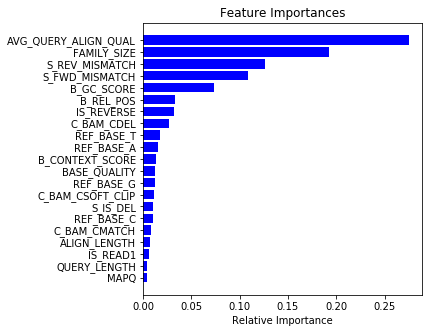

In [14]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 5, 5
features = X.columns
importances = rnd.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

AUC_ROC_CURVE

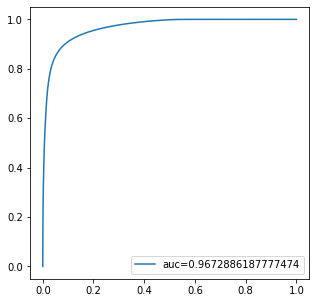

In [17]:
fpr, tpr, thresholds = roc_curve(y_val,rnd.predict_proba(X_val)[:, 1], pos_label=1)
auc = roc_auc_score(y_val,rnd.predict_proba(X_val)[:, 1])
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

PRECISION_RECALL CURVE

Average precision-recall score: 0.90


Text(0.5, 1.0, '2-class Precision-Recall curve: Average Precsion=0.90')

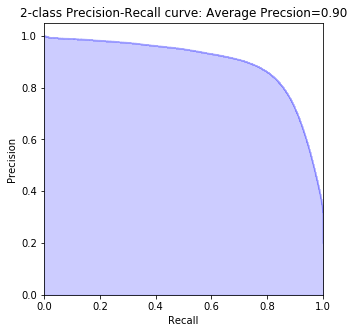

In [18]:

plt.figure(0).clf()
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_val,rnd.predict_proba(X_val)[:,1])

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))


precision, recall, _ = precision_recall_curve(y_val,rnd.predict_proba(X_val)[:,1])

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: Average Precsion={0:0.2f}'.format(
          average_precision))